**Dokumentasi model ML**
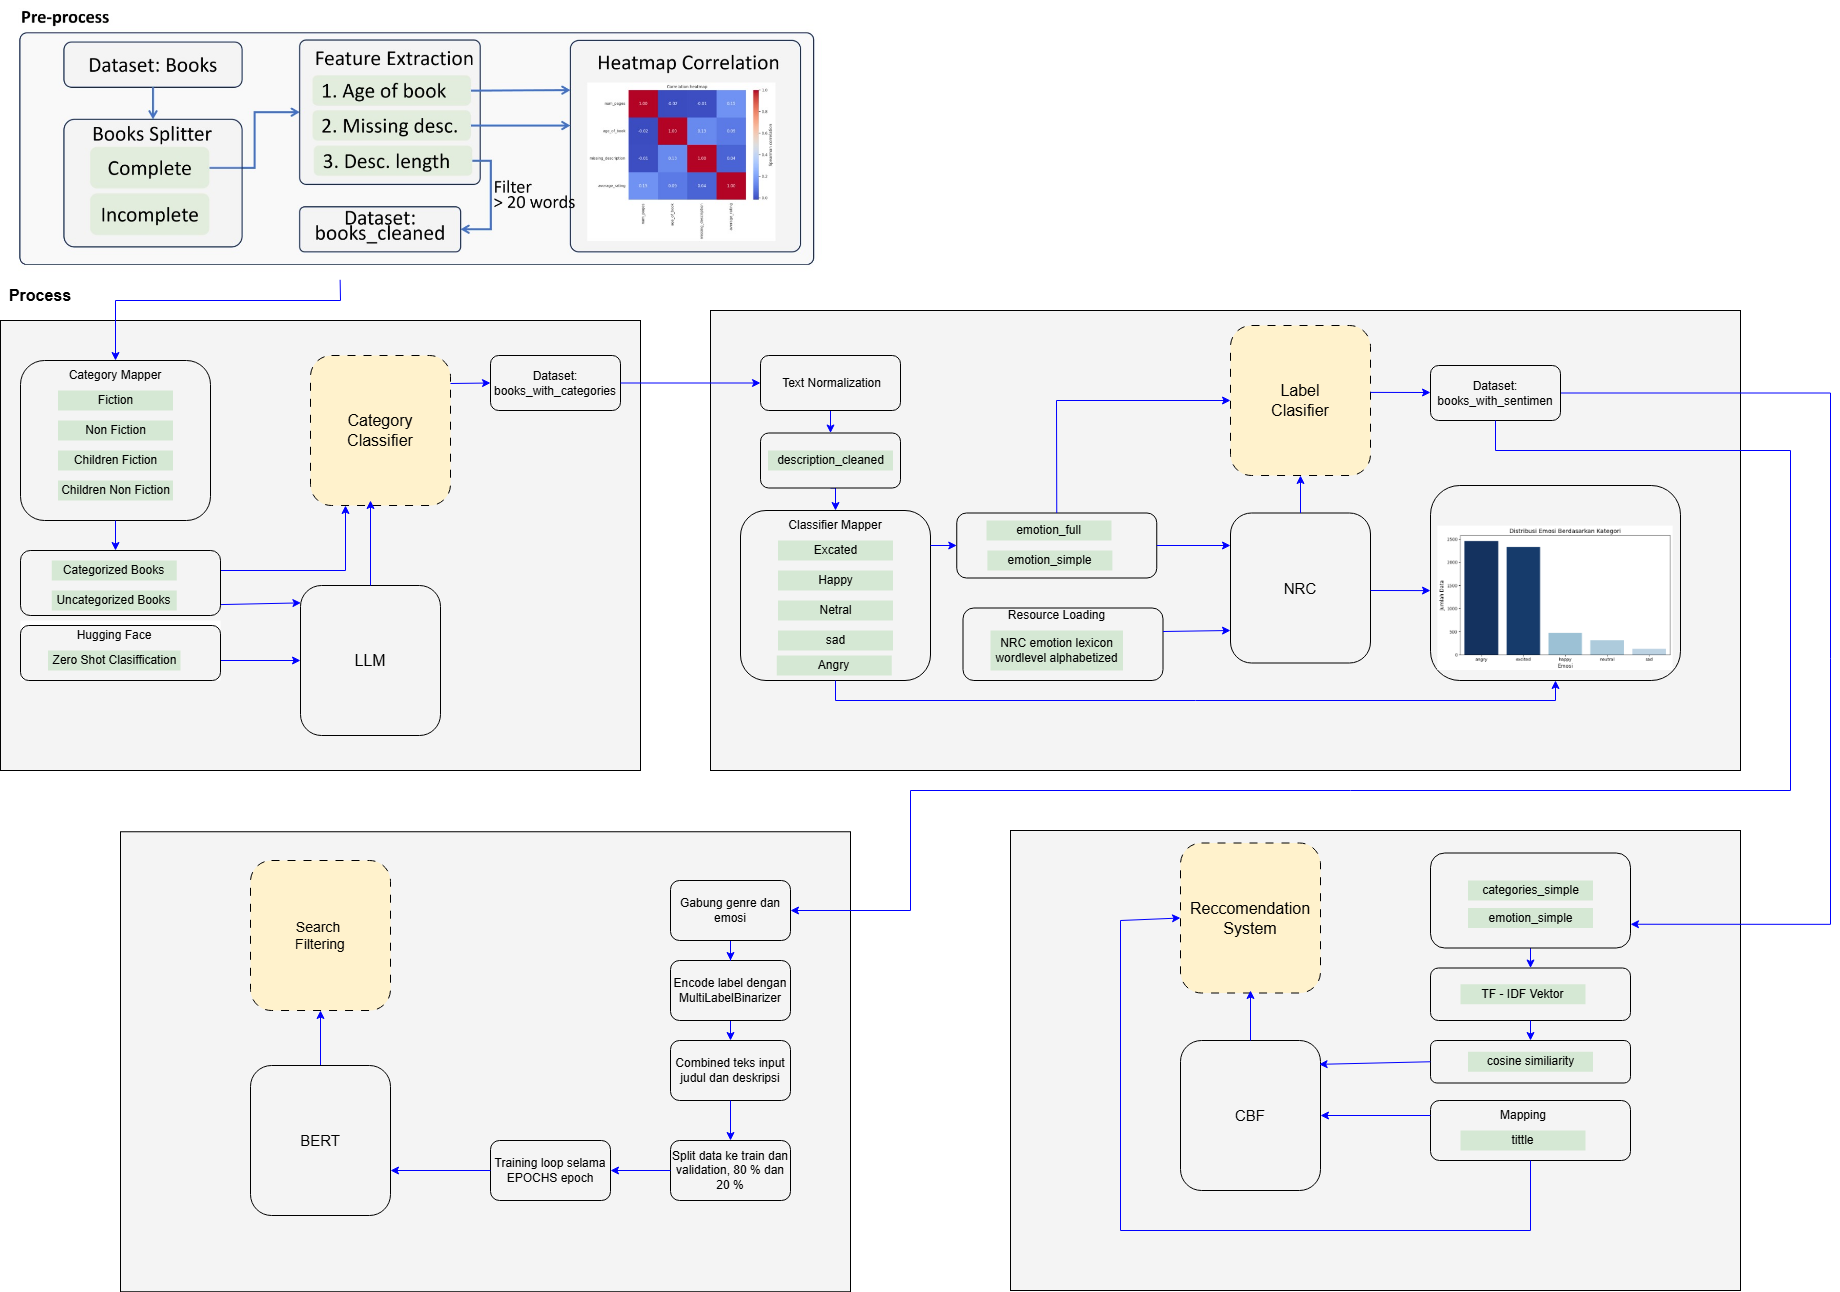

# import Library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import string
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForSequenceClassification, get_scheduler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
from transformers import TFBertForSequenceClassification
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Load Data

In [ ]:
# Upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rahmahsaryfadiyah","key":"4ea30e08f8d88f55ca614d42d07e1c63"}'}

In [ ]:
# Step 1: Pindahkan token ke direktori yang benar
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 2: Download dataset dari Kaggle
!kaggle datasets download -d dylanjcastillo/7k-books-with-metadata

# Step 3: Ekstrak dataset
import zipfile

with zipfile.ZipFile("7k-books-with-metadata.zip", 'r') as zip_ref:
    zip_ref.extractall("books_dataset")

Dataset URL: https://www.kaggle.com/datasets/dylanjcastillo/7k-books-with-metadata
License(s): CC0-1.0
  0% 0.00/1.47M [00:00<?, ?B/s]
100% 1.47M/1.47M [00:00<00:00, 790MB/s]


In [ ]:
books = pd.read_csv('/content/books_dataset/books.csv')
books.head()

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0


# Data Exploration

In [ ]:
print("Info Struktur Data:")
print(books.info(), "\n")

Info Struktur Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6810 entries, 0 to 6809
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   isbn13          6810 non-null   int64  
 1   isbn10          6810 non-null   object 
 2   title           6810 non-null   object 
 3   subtitle        2381 non-null   object 
 4   authors         6738 non-null   object 
 5   categories      6711 non-null   object 
 6   thumbnail       6481 non-null   object 
 7   description     6548 non-null   object 
 8   published_year  6804 non-null   float64
 9   average_rating  6767 non-null   float64
 10  num_pages       6767 non-null   float64
 11  ratings_count   6767 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 638.6+ KB
None 



In [ ]:
print("Statistik Deskriptif:")
print(books.describe().T, "\n")

Statistik Deskriptif:
                 count          mean           std           min  \
isbn13          6810.0  9.780677e+12  6.068911e+08  9.780002e+12   
published_year  6804.0  1.998630e+03  1.048426e+01  1.853000e+03   
average_rating  6767.0  3.933284e+00  3.313516e-01  0.000000e+00   
num_pages       6767.0  3.481810e+02  2.423768e+02  0.000000e+00   
ratings_count   6767.0  2.106910e+04  1.376207e+05  0.000000e+00   

                         25%           50%           75%           max  
isbn13          9.780330e+12  9.780553e+12  9.780810e+12  9.789042e+12  
published_year  1.996000e+03  2.002000e+03  2.005000e+03  2.019000e+03  
average_rating  3.770000e+00  3.960000e+00  4.130000e+00  5.000000e+00  
num_pages       2.080000e+02  3.040000e+02  4.200000e+02  3.342000e+03  
ratings_count   1.590000e+02  1.018000e+03  5.992500e+03  5.629932e+06   



In [ ]:
books.describe(include="object").T

,count,unique,top,freq
isbn10,6810,6810,9042003405,1
title,6810,6398,The Lord of the Rings,11
subtitle,2381,2009,A Novel,226
authors,6738,3780,Agatha Christie,37
categories,6711,567,Fiction,2588
thumbnail,6481,6481,http://books.google.com/books/content?id=2lVyR...,1
description,6548,6474,No Marketing Blurb,6


In [ ]:
print("Jumlah Duplikat:")
print(books.duplicated().sum(), "baris\n")

Jumlah Duplikat:
0 baris



In [ ]:
print(" Missing Value per Kolom:")
print(books.isnull().sum(), "\n")

 Missing Value per Kolom:
isbn13               0
isbn10               0
title                0
subtitle          4429
authors             72
categories          99
thumbnail          329
description        262
published_year       6
average_rating      43
num_pages           43
ratings_count       43
dtype: int64 



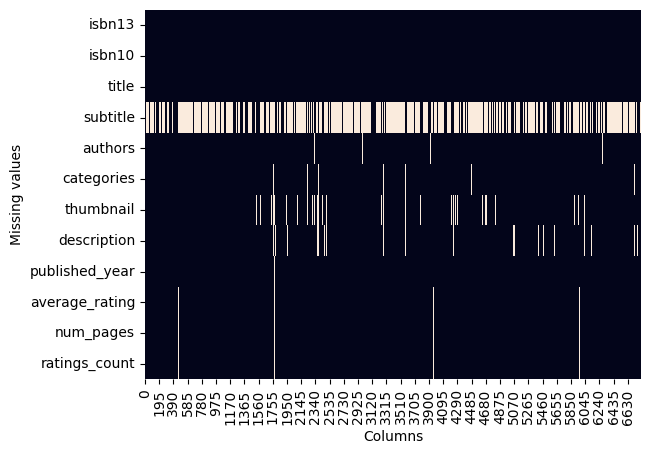

In [ ]:
ax = plt.axes()

sns.heatmap(books.isna().transpose(), cbar=False, ax=ax)

plt.xlabel("Columns")
plt.ylabel("Missing values")

plt.show()

In [ ]:
# Penambahan Fitur Baru
books["missing_description"] = np.where(books["description"].isna(), 1, 0)
books["age_of_book"] = 2025 - books["published_year"]

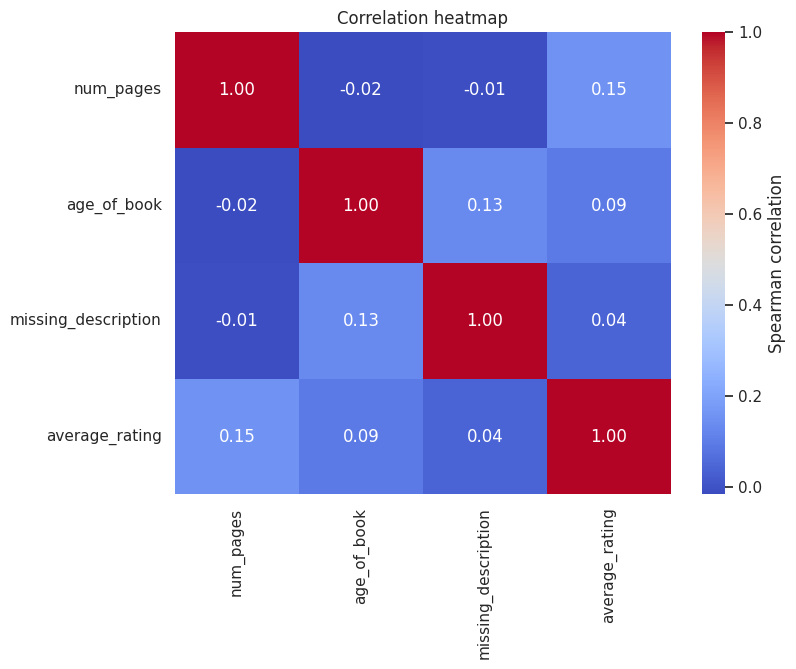

In [ ]:
columns_of_interest = ["num_pages", "age_of_book", "missing_description", "average_rating"]

# spearman is more appropiated when we are dealing with non-continous values
correlation_matrix = books[columns_of_interest].corr(method="spearman")

sns.set_theme(style="white")
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"label": "Spearman correlation"})
heatmap.set_title("Correlation heatmap")
plt.show()

In [ ]:
# Filter Data yang Lengkap
book_missing = books[
    ~(books["description"].isna()) &
    ~(books["num_pages"].isna()) &
    ~(books["average_rating"].isna()) &
    ~(books["published_year"].isna())
]

In [ ]:
book_missing.head()

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,21.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,25.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0,0,43.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,32.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,23.0


In [ ]:
# Menghitung jumlah buku per kategori.
book_missing["categories"].value_counts().reset_index().sort_values("count", ascending=False)

,categories,count
0,Fiction,2523
1,Juvenile Fiction,534
2,Biography & Autobiography,391
3,History,258
4,Literary Criticism,164
...,...,...
276,Electrons,1
275,Pigeons,1
274,Brothers and sisters,1
273,"Banks and banking, British",1


In [ ]:
# fitur words_in_description yang berisi jumlah kata dari deskripsi buku.
book_missing["words_in_description"] = book_missing["description"].str.split().str.len()

<ipython-input-19-8d98c70c2382>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_missing["words_in_description"] = book_missing["description"].str.split().str.len()


In [ ]:
book_missing.head()

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book,words_in_description
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,21.0,199
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,25.0,205
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0,0,43.0,14
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,32.0,57
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,23.0,45


In [ ]:
# Menampilkan deskripsi buku yang terlalu pendek (1 - 4 kata)
book_missing.loc[book_missing["words_in_description"].between(1, 4), "description"]

,description
6,Donation.
11,Fantasy-roman.
748,Includes bibliographical references.
770,Bound For Oregon (PB)
775,No Marketing Blurb
812,No Marketing Blurb
857,First published in 1813.
944,Edited by Maurice Hindle.
953,DEFOE/ROBINSON CRUSOE (BC)
954,Edited by John Carey.


In [ ]:
book_missing.loc[book_missing["words_in_description"].between(5, 14), "description"]

,description
2,Volume Two of Stephen Donaldson's acclaimed se...
38,Koko is Peter Straub's foray into the psycholo...
70,A matter of life and death - and the Throne of...
77,Nonsense rhyming story. 4 yrs+
84,A study guide for the novel There's a Boy in t...
...,...
6715,The first comprehensive guide to addressing Na...
6726,Presents two complete novels from Henry James.
6757,Audio Book- unabriged on CD
6776,Raymond Chandler meets The Exorcist. Classic n...


In [ ]:
book_missing.loc[book_missing["words_in_description"].between(15, 24), "description"]

,description
10,One of Sidney Sheldon's most popular and bests...
32,Tells the story of three generations of Chines...
36,A magical and fantastic collection of early st...
57,A young drifter finds more than he bargained f...
68,A new 'The Doors of Perception' for the 21st c...
...,...
6767,Everything from the fingerprints of the gods t...
6782,Displays one of America's leading physicist's ...
6783,Basics Illustration 01: Thinking Visually expl...
6789,Provides an introduction to the American artis...


In [ ]:
book_missing.loc[book_missing["words_in_description"].between(25, 34), "description"]

,description
9,Kate Blackwell is an enigma and one of the mos...
14,"Available in the U.S. for the first time, this..."
20,"It is 1937, and Charles Ashworth, a Canon to t..."
21,Reissue of the author's most famous and well-l...
46,No one believes a little girl when she insists...
...,...
6760,"Joel, an English teacher, has never really lik..."
6766,Discusses the historical and intellectual back...
6775,Presents nearly one thousand recipes--from app...
6779,Edited by the creator and executive producer o...


In [ ]:
book_missing_25_words = book_missing[book_missing["words_in_description"] >= 20]

In [ ]:
book_missing_25_words.head(2)

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book,words_in_description
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,21.0,199
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,25.0,205


In [ ]:
# Menggabungkan title dan Subtitle
book_missing_25_words[["title", "subtitle"]].astype(str).agg(": ".join, axis=1)

,0
0,Gilead: nan
1,Spider's Web: A Novel
3,Rage of angels: nan
4,The Four Loves: nan
5,The Problem of Pain: nan
...,...
6803,Journey to the East: nan
6804,The Monk Who Sold His Ferrari: A Fable About F...
6805,I Am that: Talks with Sri Nisargadatta Maharaj
6808,The Berlin Phenomenology: nan


In [ ]:
# membuat fitur title_and_subtitle
book_missing_25_words["title_and_subtitle"] = (
    np.where(book_missing_25_words["subtitle"].isna(), book_missing_25_words["title"],
             book_missing_25_words[["title", "subtitle"]].astype(str).agg(": ".join, axis=1))
)

<ipython-input-28-82047b1c5d77>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_missing_25_words["title_and_subtitle"] = (


In [ ]:
book_missing_25_words.head(2)

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book,words_in_description,title_and_subtitle
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,21.0,199,Gilead
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,25.0,205,Spider's Web: A Novel


In [ ]:
# membuat tag deskripsi untuk mengidentifikasi unik dalam text processing.
book_missing_25_words["tagged_description"] = book_missing_25_words[["isbn13", "description"]].astype(str).agg(" ".join, axis=1)

<ipython-input-30-e0dcf3f3fef3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_missing_25_words["tagged_description"] = book_missing_25_words[["isbn13", "description"]].astype(str).agg(" ".join, axis=1)


In [ ]:
book_missing_25_words.head(2)

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book,words_in_description,title_and_subtitle,tagged_description
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,21.0,199,Gilead,9780002005883 A NOVEL THAT READERS and critics...
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,25.0,205,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...


In [ ]:
save_path = "/content/drive/MyDrive/books_cleaned.csv"

(
    book_missing_25_words
    .drop(["subtitle", "missing_description", "age_of_book", "words_in_description"], axis=1)
    .to_csv(save_path, index=False)
)

print("File berhasil disimpan ke Google Drive:", save_path)

File berhasil disimpan ke Google Drive: /content/drive/MyDrive/books_cleaned.csv


# Mengkategorikan Genre menggunakan LLM

In [ ]:
csv_path = "/content/drive/MyDrive/books_cleaned.csv"
df = pd.read_csv(csv_path)

df.head()

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,title_and_subtitle,tagged_description
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,Gilead,9780002005883 A NOVEL THAT READERS and critics...
1,9780002261982,0002261987,Spider's Web,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...
2,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,Rage of angels,"9780006178736 A memorable, mesmerizing heroine..."
3,9780006280897,0006280897,The Four Loves,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,The Four Loves,9780006280897 Lewis' work on the nature of lov...
4,9780006280934,0006280935,The Problem of Pain,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5693 entries, 0 to 5692
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   isbn13              5693 non-null   int64  
 1   isbn10              5693 non-null   object 
 2   title               5693 non-null   object 
 3   authors             5646 non-null   object 
 4   categories          5662 non-null   object 
 5   thumbnail           5506 non-null   object 
 6   description         5693 non-null   object 
 7   published_year      5693 non-null   float64
 8   average_rating      5693 non-null   float64
 9   num_pages           5693 non-null   float64
 10  ratings_count       5693 non-null   float64
 11  title_and_subtitle  5693 non-null   object 
 12  tagged_description  5693 non-null   object 
dtypes: float64(4), int64(1), object(8)
memory usage: 578.3+ KB


In [ ]:
# melihat kategori yang unik
df['categories'].unique()

array(['Fiction', 'Detective and mystery stories', 'Christian life',
       'Africa, East', 'Hyland, Morn (Fictitious character)',
       'Adventure stories', 'Arthurian romances', 'Fantasy fiction', nan,
       'English drama', 'Country life', 'English fiction', 'Clergy',
       'Aubrey, Jack (Fictitious character)',
       'Detective and mystery stories, English', 'Black Death',
       'Human cloning', 'Science fiction', 'Great Britain',
       'American fiction', 'American essays', 'Capitalism', 'Ireland',
       'Juvenile Fiction', "Children's stories, English",
       'Literary Collections', 'Beresford, Tommy (Fictitious character)',
       'Imaginary wars and battles', 'Dysfunctional families',
       'Poirot, Hercule (Fictitious character)', 'Christmas stories',
       'Marple, Jane (Fictitious character)', 'Belgians',
       'Battle, Superintendent (Fictitious character)',
       'Baggins, Frodo (Fictitious character)', 'Cambridge (Mass.)',
       'Business enterprises', 'Emoti

In [ ]:
# cek jumlah perkategori
df["categories"].value_counts().reset_index()

,categories,count
0,Fiction,2269
1,Juvenile Fiction,456
2,Biography & Autobiography,348
3,History,226
4,Literary Criticism,138
...,...,...
494,"Hyland, Morn (Fictitious character)",1
495,Country life,1
496,Clergy,1
497,"Aubrey, Jack (Fictitious character)",1


In [ ]:
# cek jumlah kategori yang memiliki jumlah lebih dari 50
df["categories"].value_counts().reset_index().query("count > 50")

,categories,count
0,Fiction,2269
1,Juvenile Fiction,456
2,Biography & Autobiography,348
3,History,226
4,Literary Criticism,138
5,Philosophy,129
6,Religion,126
7,Comics & Graphic Novels,125
8,Drama,99
9,Juvenile Nonfiction,81


In [ ]:
# mengelompokkan kategori buku
category_mapping = {
    "Fiction": "Fiction",
    "Juvenile Fiction": "Children's Fiction",
    "Biography & Autobiography": "Nonfiction",
    "History": "Nonfiction",
    "Literary Criticism": "Nonfiction",
    "Philosophy": "Nonfiction",
    "Religion": "Nonfiction",
    "Comics & Graphic Novels": "Fiction",
    "Drama": "Fiction",
    "Juvenile Nonfiction": "Children's Nonfiction",
    "Science": "Nonfiction",
    "Poetry": "Fiction",
}

# Mapping Kategori Asli ke yang Disederhanakan
df["simple_categories"] = df["categories"].map(category_mapping)

In [ ]:
df

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,title_and_subtitle,tagged_description,simple_categories
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,Gilead,9780002005883 A NOVEL THAT READERS and critics...,Fiction
1,9780002261982,0002261987,Spider's Web,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...,NaN
2,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,Rage of angels,"9780006178736 A memorable, mesmerizing heroine...",Fiction
3,9780006280897,0006280897,The Four Loves,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,The Four Loves,9780006280897 Lewis' work on the nature of lov...,NaN
4,9780006280934,0006280935,The Problem of Pain,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5688,9788173031014,8173031010,Journey to the East,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,Journey to the East,9788173031014 This book tells the tale of a ma...,NaN
5689,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,The Monk Who Sold His Ferrari: A Fable About F...,9788179921623 Wisdom to Create a Life of Passi...,NaN
5690,9788185300535,8185300534,I Am that,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,I Am that: Talks with Sri Nisargadatta Maharaj,9788185300535 This collection of the timeless ...,Nonfiction
5691,9789027712059,9027712050,The Berlin Phenomenology,Georg Wilhelm Friedrich Hegel,History,http://books.google.com/books/content?id=Vy7Sk...,Since the three volume edition ofHegel's Philo...,1981.0,0.00,210.0,0.0,The Berlin Phenomenology,9789027712059 Since the three volume edition o...,Nonfiction


In [ ]:
# Memfilter Buku dengan Kategori yang Sudah Tersedia di Mapping
df[~(df["simple_categories"].isna())]

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,title_and_subtitle,tagged_description,simple_categories
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,Gilead,9780002005883 A NOVEL THAT READERS and critics...,Fiction
2,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,Rage of angels,"9780006178736 A memorable, mesmerizing heroine...",Fiction
8,9780006482079,0006482074,Warhost of Vastmark,Janny Wurts,Fiction,http://books.google.com/books/content?id=uOL0f...,"Tricked once more by his wily half-brother, Ly...",1995.0,4.03,522.0,2966.0,Warhost of Vastmark,9780006482079 Tricked once more by his wily ha...,Fiction
30,9780006646006,000664600X,Ocean Star Express,Mark Haddon;Peter Sutton,Juvenile Fiction,http://books.google.com/books/content?id=I2QZA...,Joe and his parents are enjoying a summer holi...,2002.0,3.50,32.0,1.0,Ocean Star Express,9780006646006 Joe and his parents are enjoying...,Children's Fiction
47,9780007121014,0007121016,Taken at the Flood,Agatha Christie,Fiction,http://books.google.com/books/content?id=3gWlx...,A Few Weeks After Marrying An Attractive Young...,2002.0,3.71,352.0,8852.0,Taken at the Flood,9780007121014 A Few Weeks After Marrying An At...,Fiction
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5683,9784770028969,4770028962,Coin Locker Babies,村上龍,Fiction,http://books.google.com/books/content?id=87DJw...,Rescued from the lockers in which they were le...,2002.0,3.75,393.0,5560.0,Coin Locker Babies,9784770028969 Rescued from the lockers in whic...,Fiction
5684,9788122200850,8122200850,"Cry, the Peacock",Anita Desai,Fiction,http://books.google.com/books/content?id=_QKwV...,This book is the story of a young girl obsesse...,1980.0,3.22,218.0,134.0,"Cry, the Peacock",9788122200850 This book is the story of a youn...,Fiction
5690,9788185300535,8185300534,I Am that,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,I Am that: Talks with Sri Nisargadatta Maharaj,9788185300535 This collection of the timeless ...,Nonfiction
5691,9789027712059,9027712050,The Berlin Phenomenology,Georg Wilhelm Friedrich Hegel,History,http://books.google.com/books/content?id=Vy7Sk...,Since the three volume edition ofHegel's Philo...,1981.0,0.00,210.0,0.0,The Berlin Phenomenology,9789027712059 Since the three volume edition o...,Nonfiction


In [ ]:
import torch
print("GPU tersedia:", torch.cuda.is_available())


GPU tersedia: True


In [ ]:
import os
from transformers import pipeline
from huggingface_hub import login

# Login ke Hugging Face jika token tersedia
hf_token = os.environ.get("HF_TOKEN")
if hf_token:
    login(hf_token)
else:
    print("⚠️ HF_TOKEN tidak ditemukan. Anda tetap bisa akses model publik.")

# Kategori klasifikasi
fiction_categories = ["Fiction", "Nonfiction"]

# Inisialisasi pipeline zero-shot classification
pipe = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=0  # Gunakan CUDA (GPU). Jika tidak tersedia, gunakan -1 untuk CPU.
)

⚠️ HF_TOKEN tidak ditemukan. Anda tetap bisa akses model publik.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
#  Mengambil Deskripsi Buku Pertama dari Kategori Fiction
sequence = df.loc[df["simple_categories"] == "Fiction", "description"].reset_index(drop=True)[0]

In [ ]:
# Model akan mengembalikan skor probabilitas apakah teks tersebut lebih mirip Fiction atau Nonfiction.
pipe(sequence, fiction_categories)

{'sequence': 'A NOVEL THAT READERS and critics have been eagerly anticipating for over a decade, Gilead is an astonishingly imagined story of remarkable lives. John Ames is a preacher, the son of a preacher and the grandson (both maternal and paternal) of preachers. It’s 1956 in Gilead, Iowa, towards the end of the Reverend Ames’s life, and he is absorbed in recording his family’s story, a legacy for the young son he will never see grow up. Haunted by his grandfather’s presence, John tells of the rift between his grandfather and his father: the elder, an angry visionary who fought for the abolitionist cause, and his son, an ardent pacifist. He is troubled, too, by his prodigal namesake, Jack (John Ames) Boughton, his best friend’s lost son who returns to Gilead searching for forgiveness and redemption. Told in John Ames’s joyous, rambling voice that finds beauty, humour and truth in the smallest of life’s details, Gilead is a song of celebration and acceptance of the best and the worst

In [ ]:
# Menentukan Kategori Terbaik (Highest Score)
max_index = np.argmax(pipe(sequence, fiction_categories)["scores"])

max_label = pipe(sequence, fiction_categories)["labels"][max_index]

max_label

'Fiction'

In [ ]:
# membuat fungsi prediksi kategori terbaik (prediksi model: Fiction atau Nonfiction).
def generate_predictions(sequence, categories):
    predictions = pipe(sequence, categories)
    max_index = np.argmax(predictions["scores"])
    max_label = predictions["labels"][max_index]
    return max_label


In [ ]:
from tqdm import tqdm

actual_cats = []
predicted_cats = []

for i in tqdm(range(0, 50)):
    sequence = df.loc[df["simple_categories"] == "Fiction", "description"].reset_index(drop=True)[i]
    predicted_cats += [generate_predictions(sequence, fiction_categories)]
    actual_cats += ["Fiction"]

for i in tqdm(range(0, 50)):
    sequence = df.loc[df["simple_categories"] == "Nonfiction", "description"].reset_index(drop=True)[i]
    predicted_cats += [generate_predictions(sequence, fiction_categories)]
    actual_cats += ["Nonfiction"]

100%|██████████| 50/50 [00:04<00:00, 10.23it/s]


In [ ]:
# Membuat DataFrame Evaluasi
predictions_df = pd.DataFrame({"actual": actual_cats, "predicted": predicted_cats})
predictions_df

,actual,predicted
0,Fiction,Fiction
1,Fiction,Fiction
2,Fiction,Fiction
3,Fiction,Nonfiction
4,Fiction,Fiction
...,...,...
95,Nonfiction,Nonfiction
96,Nonfiction,Nonfiction
97,Nonfiction,Nonfiction
98,Nonfiction,Nonfiction


In [ ]:
# Mengecek Akurasi Prediksi
predictions_df["correct_prediction"] = np.where(predictions_df["actual"] == predictions_df["predicted"], 1, 0)
predictions_df["correct_prediction"].sum() / len(predictions_df)

np.float64(0.81)

In [ ]:
# Memprediksi Kategori Buku yang Masih Kosong (NaN)
isbns = []
predicted_cats = []

missins_cats = df.loc[df["simple_categories"].isna(), ["isbn13", "description"]].reset_index(drop=True)

In [ ]:
from tqdm import tqdm
for i in tqdm(range(0, len(missins_cats))):
    sequence = missins_cats["description"][i]
    predicted_cats += [generate_predictions(sequence, fiction_categories)]
    isbns += [missins_cats["isbn13"][i]]

100%|██████████| 1576/1576 [02:04<00:00, 12.68it/s]


In [ ]:
# Membuat dan Menggabungkan Hasil Prediksi Kategori Kosong
missing_predicted_df = pd.DataFrame({"isbn13": isbns, "predicted_categories": predicted_cats})

In [ ]:
missing_predicted_df.head()

,isbn13,predicted_categories
0,9780002261982,Fiction
1,9780006280897,Nonfiction
2,9780006280934,Nonfiction
3,9780006380832,Nonfiction
4,9780006470229,Fiction


In [ ]:
df = pd.merge(df, missing_predicted_df, on="isbn13", how="left")
df["simple_categories"] = np.where(df["simple_categories"].isna(), df["predicted_categories"], df["simple_categories"])
df = df.drop(columns=["predicted_categories"])

In [ ]:
df.head(2)

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,title_and_subtitle,tagged_description,simple_categories
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,Gilead,9780002005883 A NOVEL THAT READERS and critics...,Fiction
1,9780002261982,0002261987,Spider's Web,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...,Fiction


In [ ]:
# Memfilter Buku Berdasarkan Genre Tertentu (case-insensitive)
df[df["categories"].str.lower().isin([
    "romance",
    "science fiction",
    "scifi",
    "fantasy",
    "horror",
    "mystery",
    "thriller",
    "comedy",
    "crime",
    "historical",
])]

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,title_and_subtitle,tagged_description,simple_categories
24,9780006513087,0006513085,Gravity,Tess Gerritsen,Science fiction,http://books.google.com/books/content?id=KI66c...,Emma Watson a research physician has been trai...,2004.0,4.04,342.0,8024.0,Gravity,9780006513087 Emma Watson a research physician...,Nonfiction
495,9780099410355,0099410354,Traitor,Matthew Woodring Stover,Science fiction,http://books.google.com/books/content?id=VbICO...,"From the depths of catastrophe, a glimmer of h...",2002.0,4.00,320.0,6765.0,Traitor,"9780099410355 From the depths of catastrophe, ...",Fiction
498,9780099422341,0099422344,Yeats is Dead!,Joseph O'Connor,Comedy,http://books.google.com/books/content?id=DrE3I...,"In aid of Amnesty International, this is a bri...",2002.0,3.39,298.0,34.0,Yeats is Dead!: A Novel by Fifteen Irish Writers,"9780099422341 In aid of Amnesty International,...",Fiction
511,9780099446729,0099446723,Blackwood Farm,Anne Rice,Horror,http://books.google.com/books/content?id=cIn8T...,"Lestat Is Back, Saviour And Demon, Presiding O...",2003.0,3.86,774.0,26145.0,Blackwood Farm,"9780099446729 Lestat Is Back, Saviour And Demo...",Fiction
1165,9780261102422,0261102427,The Silmarillion,John Ronald Reuel Tolkien,Fantasy,http://books.google.com/books/content?id=22ePu...,Tolkien's Silmarillion is the core work of the...,1999.0,3.91,384.0,253.0,The Silmarillion,9780261102422 Tolkien's Silmarillion is the co...,Fiction
1533,9780340837955,0340837950,Stranger in a Strange Land,Robert A. Heinlein,Science fiction,http://books.google.com/books/content?id=ZQhiP...,"Epic, entertaining, Stranger in a Strange Land...",2005.0,3.92,672.0,563.0,Stranger in a Strange Land,"9780340837955 Epic, entertaining, Stranger in ...",Fiction
1537,9780345251220,0345251229,Visions from Nowhere,William Arrow,Science fiction,NaN,"The first novel in the series, ""Return to the ...",1976.0,3.23,183.0,10.0,Visions from Nowhere,"9780345251220 The first novel in the series, ""...",Fiction
2289,9780439405607,0439405602,Guardians of Ga'Hoole #4: The Siege,Kathryn Lasky,Fantasy,NaN,The war between the evil group led by Soren's ...,2003.0,4.10,203.0,8964.0,Guardians of Ga'Hoole #4: The Siege,9780439405607 The war between the evil group l...,Fiction
3099,9780575075597,0575075597,Replay,Ken Grimwood,Fantasy,http://books.google.com/books/content?id=9vmNP...,At forty-three Jeff Winston is tired of his lo...,2005.0,4.16,272.0,412.0,Replay,9780575075597 At forty-three Jeff Winston is t...,Fiction
3117,9780590254762,0590254766,"The lion, the witch and the wardrobe",Clive Staples Lewis,Fantasy,NaN,Four English school children enter the magic l...,1995.0,4.21,189.0,860.0,"The lion, the witch and the wardrobe",9780590254762 Four English school children ent...,Nonfiction


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5693 entries, 0 to 5692
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   isbn13              5693 non-null   int64  
 1   isbn10              5693 non-null   object 
 2   title               5693 non-null   object 
 3   authors             5646 non-null   object 
 4   categories          5662 non-null   object 
 5   thumbnail           5506 non-null   object 
 6   description         5693 non-null   object 
 7   published_year      5693 non-null   float64
 8   average_rating      5693 non-null   float64
 9   num_pages           5693 non-null   float64
 10  ratings_count       5693 non-null   float64
 11  title_and_subtitle  5693 non-null   object 
 12  tagged_description  5693 non-null   object 
 13  simple_categories   5693 non-null   object 
dtypes: float64(4), int64(1), object(9)
memory usage: 622.8+ KB


In [ ]:
df

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,title_and_subtitle,tagged_description,simple_categories
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,Gilead,9780002005883 A NOVEL THAT READERS and critics...,Fiction
1,9780002261982,0002261987,Spider's Web,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...,Fiction
2,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,Rage of angels,"9780006178736 A memorable, mesmerizing heroine...",Fiction
3,9780006280897,0006280897,The Four Loves,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,The Four Loves,9780006280897 Lewis' work on the nature of lov...,Nonfiction
4,9780006280934,0006280935,The Problem of Pain,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le...",Nonfiction
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5688,9788173031014,8173031010,Journey to the East,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,Journey to the East,9788173031014 This book tells the tale of a ma...,Nonfiction
5689,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,The Monk Who Sold His Ferrari: A Fable About F...,9788179921623 Wisdom to Create a Life of Passi...,Fiction
5690,9788185300535,8185300534,I Am that,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,I Am that: Talks with Sri Nisargadatta Maharaj,9788185300535 This collection of the timeless ...,Nonfiction
5691,9789027712059,9027712050,The Berlin Phenomenology,Georg Wilhelm Friedrich Hegel,History,http://books.google.com/books/content?id=Vy7Sk...,Since the three volume edition ofHegel's Philo...,1981.0,0.00,210.0,0.0,The Berlin Phenomenology,9789027712059 Since the three volume edition o...,Nonfiction


In [ ]:
path = "/content/drive/MyDrive/books_with_categories.csv"
df.to_csv(path, index=False)
print("File berhasil disimpan ke Google Drive:", path)

File berhasil disimpan ke Google Drive: /content/drive/MyDrive/books_with_categories.csv


# Label analisis metode NRC Emotion Lexicon

In [ ]:
books_with_categories = pd.read_csv('/content/drive/MyDrive/books_with_categories.csv')
books_with_categories

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,title_and_subtitle,tagged_description,simple_categories
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,Gilead,9780002005883 A NOVEL THAT READERS and critics...,Fiction
1,9780002261982,0002261987,Spider's Web,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...,Fiction
2,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,Rage of angels,"9780006178736 A memorable, mesmerizing heroine...",Fiction
3,9780006280897,0006280897,The Four Loves,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,The Four Loves,9780006280897 Lewis' work on the nature of lov...,Nonfiction
4,9780006280934,0006280935,The Problem of Pain,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le...",Nonfiction
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5688,9788173031014,8173031010,Journey to the East,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,Journey to the East,9788173031014 This book tells the tale of a ma...,Nonfiction
5689,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,The Monk Who Sold His Ferrari: A Fable About F...,9788179921623 Wisdom to Create a Life of Passi...,Fiction
5690,9788185300535,8185300534,I Am that,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,I Am that: Talks with Sri Nisargadatta Maharaj,9788185300535 This collection of the timeless ...,Nonfiction
5691,9789027712059,9027712050,The Berlin Phenomenology,Georg Wilhelm Friedrich Hegel,History,http://books.google.com/books/content?id=Vy7Sk...,Since the three volume edition ofHegel's Philo...,1981.0,0.00,210.0,0.0,The Berlin Phenomenology,9789027712059 Since the three volume edition o...,Nonfiction


In [ ]:
def clean_text(text):
    # Ubah ke huruf kecil
    text = text.lower()

    # Hapus angka
    text = re.sub(r'\d+', '', text)

    # Hapus tanda baca
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Hapus white space di awal dan akhir, dan extra space di tengah
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)

    # Hapus karakter khusus seperti emoji
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)

    # Hapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Hapus mention (@user) dan hashtag (#tag)
    text = re.sub(r'@\w+|#\w+', '', text)

    return text

# Terapkan ke kolom 'content_cleaned'
# Buat salinan DataFrame books_with_categories dan beri nama books_with_sentimen
books_with_sentimen = books_with_categories.copy()
books_with_sentimen['description_cleaned'] = books_with_sentimen['description'].astype(str).apply(clean_text)
books_with_sentimen

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,title_and_subtitle,tagged_description,simple_categories,description_cleaned
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,Gilead,9780002005883 A NOVEL THAT READERS and critics...,Fiction,a novel that readers and critics have been eag...
1,9780002261982,0002261987,Spider's Web,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...,Fiction,a new christie for christmas a fulllength nove...
2,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,Rage of angels,"9780006178736 A memorable, mesmerizing heroine...",Fiction,a memorable mesmerizing heroine jennifer brill...
3,9780006280897,0006280897,The Four Loves,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,The Four Loves,9780006280897 Lewis' work on the nature of lov...,Nonfiction,lewis work on the nature of love divides love ...
4,9780006280934,0006280935,The Problem of Pain,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le...",Nonfiction,in the problem of pain cs lewis one of the mos...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5688,9788173031014,8173031010,Journey to the East,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,Journey to the East,9788173031014 This book tells the tale of a ma...,Nonfiction,this book tells the tale of a man who goes on ...
5689,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,The Monk Who Sold His Ferrari: A Fable About F...,9788179921623 Wisdom to Create a Life of Passi...,Fiction,wisdom to create a life of passion purpose and...
5690,9788185300535,8185300534,I Am that,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,I Am that: Talks with Sri Nisargadatta Maharaj,9788185300535 This collection of the timeless ...,Nonfiction,this collection of the timeless teachings of o...
5691,9789027712059,9027712050,The Berlin Phenomenology,Georg Wilhelm Friedrich Hegel,History,http://books.google.com/books/content?id=Vy7Sk...,Since the three volume edition ofHegel's Philo...,1981.0,0.00,210.0,0.0,The Berlin Phenomenology,9789027712059 Since the three volume edition o...,Nonfiction,since the three volume edition ofhegels philos...


In [ ]:
# Buat folder data jika belum ada
!mkdir -p data

# Download file NRC (tanpa overwrite jika sudah ada)
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/upshot-trump-emolex/data/NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt -P data/

File ‘data/NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt’ already there; not retrieving.



In [ ]:
def load_emolex(filepath):
    emolex = {}
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            # Skip the first line if it's a header (often starts with '#')
            # This is a common pattern in lexicon files, but may not be necessary depending on the file
            first_line = f.readline()
            if not first_line.strip().startswith('#'):
                 # If it wasn't a header, process it
                 parts = first_line.strip().split('\t')
                 if len(parts) == 3:
                    word, emotion, association_str = parts
                    try:
                        association = int(association_str)
                        if association == 1:
                            if word not in emolex:
                                emolex[word] = []
                            emolex[word].append(emotion)
                    except ValueError:
                        # Handle cases where the association is not an integer
                        print(f"Skipping line due to non-integer association: {first_line.strip()}")


            for line in f:
                # Skip empty or whitespace-only lines
                if not line.strip():
                    continue

                parts = line.strip().split('\t')
                # Check if the line has the expected number of fields
                if len(parts) == 3:
                    word, emotion, association_str = parts
                    try:
                        association = int(association_str)
                        if association == 1:
                            if word not in emolex:
                                emolex[word] = []
                            emolex[word].append(emotion)
                    except ValueError:
                        # Handle cases where the association is not an integer
                        print(f"Skipping line due to non-integer association: {line.strip()}")
                else:
                    # Print lines that don't have the expected format for debugging
                    print(f"Skipping malformed line: {line.strip()} (expected 3 fields, got {len(parts)})")
    except FileNotFoundError:
        print(f"Error: The file was not found at {filepath}. Please ensure it was downloaded correctly.")
        return None # Return None or raise the exception, depending on desired behavior
    except Exception as e:
        print(f"An unexpected error occurred while reading the file: {e}")
        return None

    return emolex

# Load file NRC yang sudah di-download
emolex = load_emolex("data/NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt")

# Optional: Check if emolex was loaded successfully
if emolex is None:
    print("Failed to load the emotion lexicon.")
else:
    print(f"Successfully loaded lexicon with {len(emolex)} words.")

Skipping malformed line: NRC Word-Emotion Association Lexicon (expected 3 fields, got 1)
Skipping malformed line: (NRC Emotion Lexicon) (expected 3 fields, got 1)
Skipping malformed line: Version 0.92 (expected 3 fields, got 1)
Skipping malformed line: 10 July 2011 (expected 3 fields, got 1)
Skipping malformed line: Copyright (C) 2011 National Research Council Canada (NRC) (expected 3 fields, got 1)
Skipping malformed line: Contact: Saif Mohammad (saif.mohammad@nrc-cnrc.gc.ca) (expected 3 fields, got 1)
Skipping malformed line: Terms of use: (expected 3 fields, got 1)
Skipping malformed line: 1. This lexicon can be used freely for research purposes. (expected 3 fields, got 1)
Skipping malformed line: 2. The papers listed below provide details of the creation and use of (expected 3 fields, got 1)
Skipping malformed line: the lexicon. If you use a lexicon, then please cite the associated (expected 3 fields, got 1)
Skipping malformed line: papers. (expected 3 fields, got 1)
Skipping malfo

In [ ]:
def analyze_emotion(text, emolex):
    emotion_counts = defaultdict(int)
    words = word_tokenize(text.lower())
    for word in words:
        emotions = emolex.get(word, [])
        for emotion in emotions:
            emotion_counts[emotion] += 1
    return dict(emotion_counts)

def simplify_emotions(emotion_counts):
    return {
        'excited': emotion_counts.get('anticipation', 0) + emotion_counts.get('surprise', 0),
        'happy': emotion_counts.get('joy', 0),
        'sad': emotion_counts.get('sadness', 0),
        'angry': emotion_counts.get('anger', 0) + emotion_counts.get('fear', 0) + emotion_counts.get('disgust', 0)
    }

def label_emotion_per_row(text, emolex):
    raw = analyze_emotion(text, emolex)
    simplified = simplify_emotions(raw)
    if all(score == 0 for score in simplified.values()):
        return 'neutral'
    max_emotion = max(simplified, key=simplified.get)
    return max_emotion

def label_emotions_full(text, emolex):
    raw = analyze_emotion(text, emolex)
    if not raw:
        return 'neutral'
    max_count = max(raw.values())
    max_emotions = [emotion for emotion, count in raw.items() if count == max_count]
    return ','.join(max_emotions)

def label_emotions_to_dataframe(df, emolex):
    df['description_cleaned'] = df['description_cleaned'].fillna('')
    df['emotion_simple'] = df['description_cleaned'].apply(lambda text: label_emotion_per_row(text, emolex))
    df['emotion_full'] = df['description_cleaned'].apply(lambda text: label_emotions_full(text, emolex))
    return df

# Terapkan langsung ke DataFrame yang sudah ada
# Mengganti books_with_categories dengan books_with_sentimen yang sudah memiliki kolom 'description_cleaned'
books_with_sentimen = label_emotions_to_dataframe(books_with_sentimen, emolex)

# Cek hasilnya
print(books_with_sentimen[['description_cleaned', 'emotion_simple', 'emotion_full']].head())
print("\nDistribusi emotion_simple:")
print(books_with_sentimen['emotion_simple'].value_counts())
print("\nDistribusi emotion_full:")
print(books_with_sentimen['emotion_full'].value_counts())

                                 description_cleaned emotion_simple  \
0  a novel that readers and critics have been eag...        excited   
1  a new christie for christmas a fulllength nove...          angry   
2  a memorable mesmerizing heroine jennifer brill...          angry   
3  lewis work on the nature of love divides love ...          happy   
4  in the problem of pain cs lewis one of the mos...          happy   

        emotion_full  
0           positive  
1           negative  
2  positive,negative  
3       joy,positive  
4           positive  

Distribusi emotion_simple:
emotion_simple
angry      2454
excited    2325
happy       473
neutral     312
sad         129
Name: count, dtype: int64

Distribusi emotion_full:
emotion_full
positive                                  2751
negative                                   851
trust                                      232
positive,trust                             191
anticipation                               120
            

In [ ]:
books_with_sentimen

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,title_and_subtitle,tagged_description,simple_categories,description_cleaned,emotion_simple,emotion_full
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,Gilead,9780002005883 A NOVEL THAT READERS and critics...,Fiction,a novel that readers and critics have been eag...,excited,positive
1,9780002261982,0002261987,Spider's Web,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...,Fiction,a new christie for christmas a fulllength nove...,angry,negative
2,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,Rage of angels,"9780006178736 A memorable, mesmerizing heroine...",Fiction,a memorable mesmerizing heroine jennifer brill...,angry,"positive,negative"
3,9780006280897,0006280897,The Four Loves,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,The Four Loves,9780006280897 Lewis' work on the nature of lov...,Nonfiction,lewis work on the nature of love divides love ...,happy,"joy,positive"
4,9780006280934,0006280935,The Problem of Pain,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le...",Nonfiction,in the problem of pain cs lewis one of the mos...,happy,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5688,9788173031014,8173031010,Journey to the East,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,Journey to the East,9788173031014 This book tells the tale of a ma...,Nonfiction,this book tells the tale of a man who goes on ...,happy,positive
5689,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,The Monk Who Sold His Ferrari: A Fable About F...,9788179921623 Wisdom to Create a Life of Passi...,Fiction,wisdom to create a life of passion purpose and...,excited,positive
5690,9788185300535,8185300534,I Am that,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,I Am that: Talks with Sri Nisargadatta Maharaj,9788185300535 This collection of the timeless ...,Nonfiction,this collection of the timeless teachings of o...,angry,trust
5691,9789027712059,9027712050,The Berlin Phenomenology,Georg Wilhelm Friedrich Hegel,History,http://books.google.com/books/content?id=Vy7Sk...,Since the three volume edition ofHegel's Philo...,1981.0,0.00,210.0,0.0,The Berlin Phenomenology,9789027712059 Since the three volume edition o...,Nonfiction,since the three volume edition ofhegels philos...,excited,positive


<ipython-input-11-c3fcc7875fa0>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=emotion_counts, x='Emotion', y='Count', palette=colors)


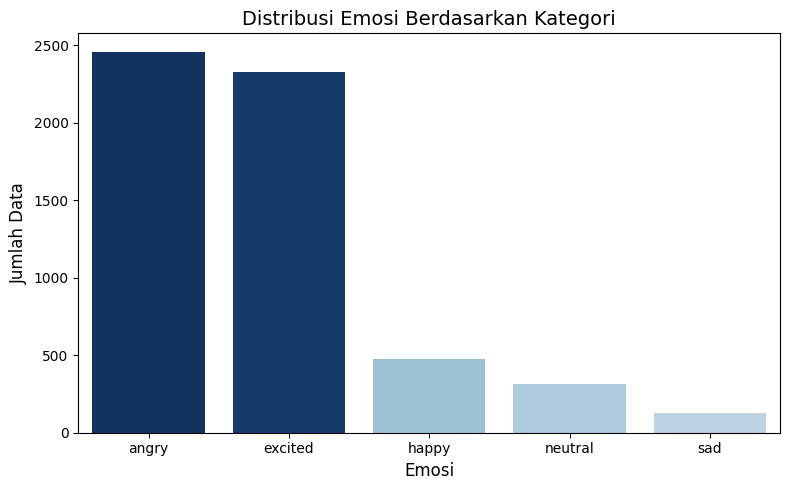

In [ ]:
# Hitung jumlah data per kategori emosi
emotion_counts = books_with_sentimen['emotion_simple'].value_counts().reset_index()
emotion_counts.columns = ['Emotion', 'Count']

# Urutkan berdasarkan jumlah (Count)
emotion_counts = emotion_counts.sort_values(by='Count', ascending=False).reset_index(drop=True)

norm = plt.Normalize(emotion_counts['Count'].min(), emotion_counts['Count'].max())
cmap = plt.cm.Blues

# Gunakan warna dari bagian bawah cmap untuk warna yang lebih gelap
colors = [cmap(0.3 + 0.7 * norm(value)) for value in emotion_counts['Count']]

# Plot diagram batang
plt.figure(figsize=(8, 5))
sns.barplot(data=emotion_counts, x='Emotion', y='Count', palette=colors)

# Tambahkan label dan judul
plt.title('Distribusi Emosi Berdasarkan Kategori', fontsize=14)
plt.xlabel('Emosi', fontsize=12)
plt.ylabel('Jumlah Data', fontsize=12)
plt.xticks(rotation=0)

# Tampilkan plot
plt.tight_layout()
plt.show()

In [ ]:
csv_filename = 'books_with_sentimen.csv'
books_with_sentimen.to_csv(csv_filename, index=False)

In [ ]:
books_with_sentimen.head()

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,title_and_subtitle,tagged_description,simple_categories,description_cleaned,emotion_simple,emotion_full
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,Gilead,9780002005883 A NOVEL THAT READERS and critics...,Fiction,a novel that readers and critics have been eag...,excited,positive
1,9780002261982,0002261987,Spider's Web,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...,Fiction,a new christie for christmas a fulllength nove...,angry,negative
2,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,Rage of angels,"9780006178736 A memorable, mesmerizing heroine...",Fiction,a memorable mesmerizing heroine jennifer brill...,angry,"positive,negative"
3,9780006280897,0006280897,The Four Loves,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,The Four Loves,9780006280897 Lewis' work on the nature of lov...,Nonfiction,lewis work on the nature of love divides love ...,happy,"joy,positive"
4,9780006280934,0006280935,The Problem of Pain,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le...",Nonfiction,in the problem of pain cs lewis one of the mos...,happy,positive


# Fine-tuned BERT

## Load Data

In [ ]:
df_bert = books_with_sentimen.copy()

## Menggabungkan genre dan emosi

In [ ]:
df_bert["combined_labels"] = df_bert.apply(lambda row: [row["simple_categories"], row["emotion_simple"]], axis=1)

## Checking distribusi label untuk mendeteksi kelas dengan sampel tunggal

In [ ]:
label_counts = Counter(tuple(labels) for labels in df_bert["combined_labels"])
single_sample_labels = [labels for labels, count in label_counts.items() if count == 1]
print("Kelas dengan 1 sampel:", single_sample_labels)

Kelas dengan 1 sampel: [("Children's Nonfiction", 'sad')]


## Filter kelas dengan 1 sampel

In [ ]:
if single_sample_labels:
    print(f"Menghapus {len(single_sample_labels)} kelas dengan satu sampel.")
    df_bert = df_bert[~df_bert["combined_labels"].apply(lambda x: tuple(x) in single_sample_labels)]

Menghapus 1 kelas dengan satu sampel.


## Encode label dengan MultiLabelBinarizer

In [ ]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df_bert["combined_labels"])
print("Label kelas:", mlb.classes_)

Label kelas: ["Children's Fiction" "Children's Nonfiction" 'Fiction' 'Nonfiction'
 'angry' 'excited' 'happy' 'neutral' 'sad']


## Combined teks input judul dan deskripsi

In [ ]:
df_bert["input_text"] = df_bert["title"] + ". " + df_bert["description"]

## Tokenisasi dengan BERT Tokenizer

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained("indobenchmark/indobert-base-p1")

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

## Class BookDataset (Handling data tokenisasi dan label)

In [ ]:
class BookDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.float)
        }

## Split data ke train dan validation dengan stratifikasi, fallback tanpa stratifikasi jika error

In [ ]:
try:
    X_train, X_val, y_train, y_val = train_test_split(
        df_bert["input_text"], y, test_size=0.2, random_state=42, stratify=y
    )
except ValueError as e:
    print(f"Stratifikasi gagal: {e}. Menggunakan train_test_split tanpa stratifikasi.")
    X_train, X_val, y_train, y_val = train_test_split(
        df_bert["input_text"], y, test_size=0.2, random_state=42
    )

train_dataset = BookDataset(X_train.tolist(), y_train, tokenizer)
val_dataset = BookDataset(X_val.tolist(), y_val, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

## Hitung class weights untuk weighted loss pada BCEWithLogitsLoss

In [ ]:
pos_weight = (y_train.shape[0] - y_train.sum(axis=0)) / (y_train.sum(axis=0) + 1e-10)
pos_weight = torch.tensor(pos_weight, dtype=torch.float).to('cuda' if torch.cuda.is_available() else 'cpu')

## Load model BERT untuk multi-label classification

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p1",
    num_labels=y.shape[1],
    problem_type="multi_label_classification"
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Setup optimizer, loss function dengan pos_weight, dan learning rate scheduler

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
EPOCHS = 10

num_training_steps = len(train_loader) * EPOCHS
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

## Training loop selama EPOCHS epoch

In [ ]:
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Epoch 1, Loss: 0.9796
Epoch 2, Loss: 0.8200
Epoch 3, Loss: 0.6384
Epoch 4, Loss: 0.4741
Epoch 5, Loss: 0.3634
Epoch 6, Loss: 0.2796
Epoch 7, Loss: 0.2198
Epoch 8, Loss: 0.1791
Epoch 9, Loss: 0.1533
Epoch 10, Loss: 0.1369


# Content-based Filtering

## Load Data untuk sistem rekomendasi

In [ ]:
df_rekomendasi = books_with_sentimen.copy()

## Menggunakan 'emotion_simple' dan 'simple_categories' sebagai teks dasar

In [ ]:
df_rekomendasi["content"] = (
    df_rekomendasi["emotion_simple"].fillna("") + " " + df_rekomendasi["simple_categories"].fillna("")
)

## Ubah teks jadi TF-IDF vector

In [ ]:
vectorizer = TfidfVectorizer(stop_words="english")
tfidf_matrix = vectorizer.fit_transform(df_rekomendasi["content"])

## Hitung cosine similarity antar semua buku

In [ ]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

## Mapping dari title ke index

In [ ]:
title_to_index = pd.Series(df_rekomendasi.index, index=df_rekomendasi["title"]).drop_duplicates()

## Fungsi Rekomendasi Buku

In [ ]:
def rekomendasikan_buku(judul_buku_input, top_n=5):
    if judul_buku_input not in title_to_index:
        return f"Buku '{judul_buku_input}' tidak ditemukan dalam data."

    idx = title_to_index[judul_buku_input]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]

    book_indices = [i[0] for i in sim_scores]
    return df_rekomendasi.loc[book_indices, [
        "title",
        "authors",
        "simple_categories",
        "description_cleaned",
        "emotion_simple",
        "average_rating",
        "num_pages",
        "published_year",
        "thumbnail"
    ]]

## Penggunaan Rekomendasi Buku

In [ ]:
rekomendasikan_buku("Rage of angels", top_n=10)

,title,authors,simple_categories,description_cleaned,emotion_simple,average_rating,num_pages,published_year,thumbnail
2,Rage of angels,Sidney Sheldon,Fiction,a memorable mesmerizing heroine jennifer brill...,angry,3.93,512.0,1993.0,http://books.google.com/books/content?id=FKo2T...
8,Warhost of Vastmark,Janny Wurts,Fiction,tricked once more by his wily halfbrother lysa...,angry,4.03,522.0,1995.0,http://books.google.com/books/content?id=uOL0f...
9,The Once and Future King,Terence Hanbury White,Fiction,an omnibus volume of the authors complete stor...,angry,4.04,823.0,1996.0,http://books.google.com/books/content?id=Jx6Bv...
11,Jimmy the Hand,Raymond E. Feist;S. M. Stirling,Fiction,jimmy the hand boy thief of krondor lived in t...,angry,3.95,368.0,2003.0,http://books.google.com/books/content?id=hV4-o...
12,Well of Darkness,Margaret Weis;Tracy Hickman,Fiction,gareth is just a frightened young lad when he ...,angry,3.66,599.0,2001.0,http://books.google.com/books/content?id=XrwaA...
13,Witness for the Prosecution & Selected Plays,Agatha Christie,Fiction,newlyjacketed edition designed to celebrate th...,angry,4.05,352.0,1995.0,http://books.google.com/books/content?id=_9u7A...
14,The Little House,Philippa Gregory,Fiction,it was easy for elizabeth she married the man ...,angry,3.66,368.0,1998.0,http://books.google.com/books/content?id=rbvUP...
18,The Mad Ship,Robin Hobb,Fiction,fantasy master robin hobb delivers the stunnin...,angry,4.24,906.0,2000.0,http://books.google.com/books/content?id=2iWez...
19,Post Captain,Patrick O'Brian,Fiction,this tale begins with jack aubrey arriving hom...,angry,4.29,474.0,1996.0,http://books.google.com/books/content?id=S761k...
20,The Reverse of the Medal,Patrick O'Brian,Fiction,in this book jack aubrey returns from his duti...,angry,4.41,261.0,1997.0,http://books.google.com/books/content?id=YtjxF...


# Evaluasi Model

In [ ]:
model.eval()
y_true, y_pred = [], []

threshold = 0.5

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].cpu().numpy()

        outputs = model(input_ids, attention_mask=attention_mask)
        probs = torch.sigmoid(outputs.logits).cpu().numpy()

        preds = (probs >= threshold).astype(int)

        y_true.extend(labels)
        y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(classification_report(y_true, y_pred, target_names=mlb.classes_, zero_division=0))

                       precision    recall  f1-score   support

   Children's Fiction       0.46      0.51      0.48        91
Children's Nonfiction       0.24      0.25      0.24        16
              Fiction       0.79      0.81      0.80       605
           Nonfiction       0.77      0.79      0.78       427
                angry       0.69      0.72      0.71       490
              excited       0.60      0.70      0.65       465
                happy       0.39      0.47      0.43        95
              neutral       0.36      0.41      0.39        63
                  sad       0.17      0.12      0.14        26

            micro avg       0.67      0.72      0.69      2278
            macro avg       0.50      0.53      0.51      2278
         weighted avg       0.67      0.72      0.70      2278
          samples avg       0.69      0.72      0.70      2278



# Save Model

In [ ]:
model.save_pretrained("/content/drive/MyDrive/bert_emotion_model_tf")

In [ ]:
model.save_pretrained("/content/drive/MyDrive/bert_emotion_model")
tokenizer.save_pretrained("/content/drive/MyDrive/bert_emotion_model")

('/content/drive/MyDrive/bert_emotion_model/tokenizer_config.json',
 '/content/drive/MyDrive/bert_emotion_model/special_tokens_map.json',
 '/content/drive/MyDrive/bert_emotion_model/vocab.txt',
 '/content/drive/MyDrive/bert_emotion_model/added_tokens.json',
 '/content/drive/MyDrive/bert_emotion_model/tokenizer.json')

In [ ]:
from transformers import BertForSequenceClassification, TFBertForSequenceClassification

# Load model PyTorch
pytorch_model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/bert_emotion_model_tf')

# Convert ke TensorFlow model (from_pt=True)
tf_model = TFBertForSequenceClassification.from_pretrained('/content/drive/MyDrive/bert_emotion_model_tf', from_pt=True)

# Simpan ke SavedModel format
tf_model.save('/content/drive/MyDrive/bert_emotion_model_tf')

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


# Konversi TFJS

In [ ]:
!pip install tensorflowjs

In [ ]:
!tensorflowjs_converter \
  --input_format=tf_saved_model \
  --output_format=tfjs_graph_model \
  /content/drive/MyDrive/bert_emotion_model_tf \
  /content/drive/MyDrive/bert_emotion_tfjs

2025-05-29 15:19:51.797472: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748531991.858081    7588 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748531991.885875    7588 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-29 15:19:59.074837: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1748531999.075003    7588 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [ ]:
import os # Import the os module

model_data = {
    "vocabulary": vectorizer.vocabulary_,  # dict: token -> index
    "idf": vectorizer.idf_.tolist(),       # list idf values aligned by index
}

# Define the directory path
output_dir = "/content/drive/MyDrive/cbf"

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define the full file path
output_file_path = os.path.join(output_dir, "tfidf_model.json")

# Open and save the file
with open(output_file_path, "w") as f:
    json.dump(model_data, f)

print(f"data saved to: {output_file_path}") # Optional: Add a confirmation message

data saved to: /content/drive/MyDrive/cbf/tfidf_model.json


In [ ]:
tfidf_dense = tfidf_matrix.toarray().tolist()
with open("/content/drive/MyDrive/cbf/tfidf_matrix.json", "w") as f:
    json.dump(tfidf_dense, f)

In [ ]:
title_to_index_dict = title_to_index.to_dict()
with open("/content/drive/MyDrive/cbf/title_to_index.json", "w") as f:
    json.dump(title_to_index_dict, f)

In [ ]:
book_data = df_rekomendasi[[
        "title",
        "authors",
        "simple_categories",
        "description_cleaned",
        "emotion_simple",
        "average_rating",
        "num_pages",
        "published_year",
        "thumbnail"
]].to_dict(orient="index")

with open("/content/drive/MyDrive/cbf/book_data.json", "w") as f:
    json.dump(book_data, f)


# Inverence

In [ ]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import torch

# 1. Load model
model_path = '/content/drive/MyDrive/bert_emotion_model'
model = SentenceTransformer(model_path)

# 2. Query dari user
query = "i'm so happy"

# 3. Filter genre dan emosi
filtered_df = df_rekomendasi[
    (df_rekomendasi['simple_categories'].str.contains('NonFiction', case=False, na=False)) &
    (df_rekomendasi['emotion_simple'].str.lower() == 'happy')
].copy()

# Pastikan deskripsi tidak kosong
title = filtered_df['title'].fillna("").tolist()

# 4. Encode query dan deskripsi
query_embedding = model.encode(query, convert_to_tensor=True)
title_embeddings = model.encode(title, convert_to_tensor=True)

# 5. Hitung cosine similarity
cosine_scores = util.cos_sim(query_embedding, title_embeddings)[0]

# 6. Tambahkan skor similarity ke dataframe hasil filter
filtered_df['similarity'] = cosine_scores.cpu().numpy()

# 7. Ambil 10 rekomendasi teratas
top_books = filtered_df.sort_values(by='similarity', ascending=False).head(10)

# 8. Output
print("Rekomendasi Buku (Genre: Fiction, Emosi: Happy):")
display(top_books[['thumbnail', 'title', 'authors', 'published_year', 'average_rating',
                   'num_pages', 'simple_categories', 'description_cleaned',
                   'emotion_simple', 'similarity']])

Rekomendasi Buku (Genre: Fiction, Emosi: Happy):


,thumbnail,title,authors,published_year,average_rating,num_pages,simple_categories,description_cleaned,emotion_simple,similarity
4181,http://books.google.com/books/content?id=oPYCN...,Always Enough,Rolland Baker;Heidi Baker,2003.0,4.45,192.0,Nonfiction,discover gods modern miracles on the mission f...,happy,0.804150
4682,http://books.google.com/books/content?id=51wMA...,"Yes, Your Teen Is Crazy!",Michael J. Bradley,2002.0,4.30,332.0,Nonfiction,a survival guide for parents helps beleagured ...,happy,0.797684
3129,http://books.google.com/books/content?id=OHxxH...,Koko's Kitten,Francine Patterson;Ronald H. Cohn,1987.0,4.30,32.0,Children's Nonfiction,tells the story of a gorilla that communicates...,happy,0.791296
3771,http://books.google.com/books/content?id=Vc56P...,Getting the Love You Want,Harville Hendrix,2005.0,4.07,336.0,Nonfiction,originally published in getting the love you w...,happy,0.786488
3529,NaN,Where Is Baby's Mommy?,Karen Katz,2001.0,4.15,14.0,Children's Nonfiction,is mommy behind the chair is mommy behind the ...,happy,0.781458
5659,http://books.google.com/books/content?id=InkFA...,Bird Songs,Les Beletsky,2006.0,4.47,368.0,Nonfiction,drawing from the collection of the worldrenown...,happy,0.780072
1100,http://books.google.com/books/content?id=lZZQA...,The Actor in You,Robert L. Benedetti,2005.0,3.70,160.0,Nonfiction,the actor in youenhances the reader s apprecia...,happy,0.779315
455,http://books.google.com/books/content?id=Sj4UD...,Pioneer Girl,William Anderson,2000.0,4.15,32.0,Children's Nonfiction,the pioneer spirit lives on readers around the...,happy,0.767989
3389,http://books.google.com/books/content?id=BG207...,A Midwife's Tale,Laurel Ulrich,1991.0,3.99,444.0,Nonfiction,presents the life of martha ballard a midwife ...,happy,0.751660
843,NaN,The Spy who Loved Me,Ian Fleming,1962.0,3.40,198.0,Nonfiction,james bond has known quite a few women but the...,happy,0.750489


In [ ]:
df_rekomendasi['simple_categories'].unique()